This walkthrough-style Jupyter notebook will detail the methodology used to evaluate the predictive performance of the underlying forecasting models in the Residential Energy Demand Forecasting Pipeline.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import pickle as pkl
import torch as t
from scipy.stats import wilcoxon
import plotly.graph_objects as go
import os
import warnings
import model_definitions as md
import preprocessing as pp
import numpy as np
import get_data as gd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
saved_data_directory = "Saved"
load_model = True

Fit Forecasting Model on all training data

Load best fitting Forecaster object or fit a new one

In [3]:
model_path = r"{}/Models/forecaster.pkl".format(saved_data_directory)

if load_model and os.path.exists(model_path): # load existing model
    with open(model_path, "rb") as file:
        model = pkl.load(file)

else: # fit new model - want to load these from repository
    best_pv_hyperparameters = {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'point_var_lags': 10, 'minimum_error_prediction': 100, 'error_trend': 100}
    best_lstm_hyperparameters = {"batch_size":100, "lr":0.0005, "dropout":0.1, "num_layers":1, "hidden_size":32, "sequence_length":24*7*3, "max_epochs":100}

    # load in clean dataset
    clean_data = pd.read_csv(r"Saved/Datasets/clean_training.csv", index_col=0)
    clean_data.index = pd.to_datetime(clean_data.index)
    clean_data.loc[clean_data["HourlyPrecipitation"].isna(),"HourlyPrecipitation"] = "None"
    display(clean_data.shape)
    # clean_data.loc[:,"HourlyPrecipitation"] = clean_data["HourlyPrecipitation"].replace({np.nan:"None"})

    # define model
    model = md.Forecaster(short_term_horizon=24)

    # fit model
    warnings.filterwarnings('ignore')
    model.fit(clean_training_data=clean_data, dependent_variable="Energy Demand (MWH)", 
        hyperparameters=best_pv_hyperparameters | best_lstm_hyperparameters, verbose=False)

(46068, 11)

<br>

# Validation

### Evaluating the Model on Holdout Data

With a final optimized forecasting model defined, it is important to evaluate its performance on unseen data and to contextualize that performance by comparing it with the performance of a baseline model. Below, we load the holdout dataset that was set aside during the processing phase of the pipeline and use it to evaluate the final forecasting model. The *Forecaster* class produces forecasts when the *predict* function is called and given a number, *hours_ahead*, of forecasts to predict. It returns both point forecasts and variance forecasts which can be used to create confidence intervals or relative confidence measures for each point forecasts. 

Below, we produce these forecasts and plot them alongside the actual values. The variance forecasts are used to calculate a 95% confidence interval (CI) for each point forecast.

### Evaluate Long-term Forecasting Performance

In [4]:
# load holdout data
evaluation_data = pd.read_csv(r"Saved/Datasets/holdout.csv", index_col=0)
evaluation_data.index = pd.to_datetime(evaluation_data.index)

# process holdout data
processor_path = r"{}/Models/processor.pkl".format(saved_data_directory)

# load existing processor (this is needed to process evaluation data)
with open(processor_path, "rb") as file:
    processor = pkl.load(file)
    processor.produce_eda_plots = False
    
# processor = pp.PreprocessingPipeline(save_datasets=False, produce_eda_plots=False)
evaluation_data, _ = processor.process_dataset(evaluation_data, train=False) # HERE need to use previous Processor to process this dataset, use the same Prophet models to impute values
evaluation_data.loc[evaluation_data["HourlyPrecipitation"].isna(),"HourlyPrecipitation"] = "None"
display(evaluation_data["HourlyPrecipitation"].value_counts(dropna=False))

Interpolating for variable Energy Demand (MWH)
Interpolating for variable HourlyDryBulbTemperature
Interpolating for variable HourlyDewPointTemperature
Interpolating for variable HourlyWetBulbTemperature
Interpolating for variable HourlyStationPressure
Interpolating for variable HourlyWindSpeed
Interpolating for variable Energy Price (cents/KWH)
Interpolating for variable Civilian Noninstitutional Population
Interpolating for variable Labor Force Participation
Interpolating for variable CPI-U
Interpolating for variable HourlyPrecipitation


HourlyPrecipitation
None           4574
Light Rain      351
Medium Rain     179
Heavy Rain       15
Name: count, dtype: int64

In [27]:
# get complete range to be predicted (in case the holdout set is missing any values)
complete_range = pd.date_range(start=evaluation_data.index.min(), end=evaluation_data.index.max(), freq='H')

# produce long-term forecasts
lt_forecasts = model.long_term_predict(complete_range.shape[0])

# reconcile forecasts and ground truth values
results = pd.merge(lt_forecasts, evaluation_data, left_index=True, right_index=True, how="inner")
point_forecasts = results["Point Forecasts"].values
variance_forecasts = results["Variance Forecasts"].values
actual_values = results["Energy Demand (MWH)"]

display(lt_forecasts)

,Point Forecasts,Variance Forecasts
ds,,
2023-09-20 17:00:00,5939.596219,261565.557275
2023-09-20 18:00:00,5994.287436,289427.543474
2023-09-20 19:00:00,6048.001362,326064.350681
2023-09-20 20:00:00,6090.931726,363801.683989
2023-09-20 21:00:00,6112.973559,387122.922730
...,...,...
2024-04-20 20:00:00,4851.548245,678946.498183
2024-04-20 21:00:00,4846.972954,700133.193282
2024-04-20 22:00:00,4820.972776,694781.283829


In [46]:
# Combine error forecasts
std_forecasts = np.sqrt(variance_forecasts)

# 1.96 is the z-value for the 2.5th percentile of the standard normal distribution
lower_cuts = point_forecasts - 1.96 * std_forecasts  
upper_cuts = point_forecasts + 1.96 * std_forecasts

# Create figure showing forecasts and actual values
long_term_fig = go.Figure()
long_term_fig.add_trace(go.Scatter(x=evaluation_data.index, y=point_forecasts, mode='lines', 
    name='Point Forecasts', line=dict(color='rgba(255, 0, 0)')))
long_term_fig.add_trace(go.Scatter(x=evaluation_data.index, y=actual_values, mode='lines', 
    name='Ground Truth', line=dict(color='rgba(0, 0, 255)')))
long_term_fig.add_trace(go.Scatter(x=evaluation_data.index, y=upper_cuts, mode='lines', 
    name='Upper 95 CI', line=dict(color='rgba(0, 255, 0, 0.2)')))
long_term_fig.add_trace(go.Scatter(x=evaluation_data.index, y=lower_cuts, mode='lines', 
    name='Lower 95 CI', line=dict(color='rgba(200, 125, 200, 0.2)')))

# Customize the layout
long_term_fig.update_layout(
    title="Long-term Evaluation of Forecasting Pipeline with Holdout Data",
    xaxis_title='Time',
    yaxis_title='Energy Demand (MWH)',
    template='plotly_dark' 
)

# save plotly figure for web application
with open(r"assets/long_term_evaluation_plot.pkl", 'wb') as file:
    pkl.dump(long_term_fig, file=file)

long_term_fig.show()

In [98]:
### statistical comparison between baseline forecasting model and created forecasting model ###

# define baseline model as simple year-long moving average
sma = clean_data["Energy Demand (MWH)"].rolling(window=24*365).mean()
baseline_prediction = sma.iloc[-1]
sma_error = pd.merge(clean_data["Energy Demand (MWH)"], sma, left_index=True, right_index=True, 
    how="inner", suffixes=["_actual", "_baseline_prediction"])
sma_error = sma_error[sma_error["Energy Demand (MWH)_baseline_prediction"].notna()]
sma_variance = pd.Series((sma_error["Energy Demand (MWH)_baseline_prediction"] - 
    sma_error["Energy Demand (MWH)_actual"]).values**2).rolling(window=24*365).mean()
baseline_variance = sma_variance.iloc[-1]

# calculate errors from baseline model
baseline_errors = actual_values - baseline_prediction

# calculate errors from project model
model_errors = actual_values - point_forecasts

### calculate all measures for Forecasting Pipeline's long-term forecasts ###
# mse
pipeline_mse = np.sum((model_errors**2))/model_errors.shape[0]

# wmse
relative_confidence = 1/std_forecasts
relative_confidence = relative_confidence/np.sum(relative_confidence) * relative_confidence.shape[0]
pipeline_wmse = np.sum(relative_confidence * 
    (point_forecasts - actual_values)**2)/actual_values.shape[0]

# mae
pipeline_mae = np.sum(np.abs(model_errors))/model_errors.shape[0]

# mape
pipeline_mape = np.sum(np.abs(model_errors/actual_values))/model_errors.shape[0]

### calculate all measures for baseline model ###
# mse
baseline_mse = np.sum((baseline_errors**2))/baseline_errors.shape[0]
baseline_wmse = baseline_mse

# mae
baseline_mae = np.sum(np.abs(baseline_errors))/baseline_errors.shape[0]

# mape
baseline_mape = np.sum(np.abs(baseline_errors/actual_values))/baseline_errors.shape[0]

# calculate all measures for EIA forecasts

# compare MSE values
print("Baseline MSE: {:.2f}".format(baseline_mse))
print("Project Model MSE: {:.2f}".format(pipeline_mse))

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(baseline_errors, model_errors)

# Output the test statistic and p-value
print("\nWilcoxon signed-rank test statistic:", statistic)
print("p-value: {:.4f}".format(p_value))

# Interpret the results
print("Outcome of Statistical Test:")
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between the two models.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the two models.")

# compare weighted MSE to regular MSE to see if confidence values help

print("\nProject Model Weighted MSE: {:.2f}".format(pipeline_wmse))

Baseline MSE: 601707.48
Project Model MSE: 131132.72

Wilcoxon signed-rank test statistic: 2905955.0
p-value: 0.0000
Outcome of Statistical Test:
Reject the null hypothesis. There is a significant difference between the two models.

Project Model Weighted MSE: 128252.87


In [47]:
# include MSE, wmse, Mape, weighted mape, statistical significance of each compared to baseline model
# create dataframe with results - easy to convert to html.
long_results_df = pd.DataFrame(index=["Forecasting Pipeline", "Baseline Yearly MA"], 
    data={"MSE":[pipeline_mse, baseline_mse], "Weighted MSE":[pipeline_wmse, baseline_wmse], 
    "MAE":[pipeline_mae, baseline_mae], "MAPE":[pipeline_mape, baseline_mape], "Wilcoxon Test p-value":[p_value, np.nan]}).round(2)
long_results_df.to_csv(r"assets/long_term_performance_report.csv")

### Evaluate Short-term Forecasting Performance

In [5]:
eia_forecast_data = gd.get_eia_forecasts(start=np.datetime64("2018-06-19"), end=np.datetime64("2024-04-21"))["EIA Forecast (MWH)"]

Requesting EIA energy demand forecast data from EIA over 11 requests


Obtain baseline model from EIA

In [6]:
eia_forecasts = eia_forecast_data[eia_forecast_data.index < evaluation_data.index.min()]
training_energy_demand = pd.read_csv(r"Saved/Datasets/preliminary.csv", index_col=0)["Energy Demand (MWH)"]
training_energy_demand.index = pd.to_datetime(training_energy_demand.index)
training_energy_demand = training_energy_demand[(training_energy_demand.index < evaluation_data.index.min())]
eia_forecasts = eia_forecasts[eia_forecasts.index.isin(training_energy_demand.index)]

coef = np.dot(eia_forecasts.values, training_energy_demand.values)/np.dot(eia_forecasts.values, eia_forecasts.values)
eia_forecasts = eia_forecast_data[eia_forecast_data.index.isin(evaluation_data.index)] * coef
display(eia_forecasts.shape)

(5095,)

In [7]:
sequence_length = 3*7*24
last_n_training = clean_data.iloc[-(sequence_length+model.short_term_horizon):]
evaluation_data_st = pd.concat([last_n_training, evaluation_data], axis=0)
evaluation_data_st.loc[evaluation_data_st["HourlyPrecipitation"].isna(),"HourlyPrecipitation"] = "None"

Calculate baseline short-term moving average

In [8]:
# define baseline short-term forecasting model as simple daily moving average
short_term_ma_period = model.short_term_horizon
last_n_training = clean_data.iloc[-(short_term_ma_period*2):]
evaluation_data_st = pd.concat([last_n_training, evaluation_data], axis=0)
evaluation_data_st.loc[evaluation_data_st["HourlyPrecipitation"].isna(),"HourlyPrecipitation"] = "None"

sma = evaluation_data_st["Energy Demand (MWH)"].rolling(window=short_term_ma_period).mean()
# sma = evaluation_data_st["Energy Demand (MWH)"].shift(short_term_ma_period)
sma = sma[sma.notna()]
sma_error = pd.merge(evaluation_data_st["Energy Demand (MWH)"], sma, left_index=True, right_index=True, 
    how="inner", suffixes=["_actual", "_baseline_prediction"])
sma_variance = pd.Series((sma_error["Energy Demand (MWH)_baseline_prediction"] - 
    sma_error["Energy Demand (MWH)_actual"]).values**2).rolling(window=short_term_ma_period).mean()

sma_forecasts = pd.DataFrame(index=sma.index, data={"Baseline MA Point Forecast":sma.values, "Baseline MA Error Forecast":sma_variance.values})
sma_forecasts = sma_forecasts[sma_forecasts["Baseline MA Error Forecast"].notna()]

Calculate Forecasting Pipeline short-term forecasts

In [23]:
sequence_length = 3*7*24
last_n_training = clean_data.iloc[-(sequence_length+model.short_term_horizon-1):]
evaluation_data_st = pd.concat([last_n_training, evaluation_data], axis=0)
loader, _, _, _ = model.format_lstm_data(evaluation_data_st, sequence_length=sequence_length, batch_size=evaluation_data_st.shape[0]-sequence_length, 
                forecasting_steps_ahead=model.short_term_horizon, proportion_validation=0)

In [24]:
display(len([x for x in loader.dataset]))
# display(loader.data)

5119

In [32]:
sequence_length = 3*7*24
last_n_training = clean_data.iloc[-(sequence_length+model.short_term_horizon-1):]
print(last_n_training.shape[0] - sequence_length)
evaluation_data_st = pd.concat([last_n_training, evaluation_data], axis=0)
evaluation_data_st.loc[evaluation_data_st["HourlyPrecipitation"].isna(),"HourlyPrecipitation"] = "None"

st_forecasts = model.short_term_predict(evaluation_data_st, expected_output_size=evaluation_data.shape[0], 
    lstm_sequence_length=sequence_length)
display(st_forecasts)

23
5119
5119


,Point Forecast,Variance Forecast
2023-09-20 17:00:00,5804.638672,3605.561351
2023-09-20 18:00:00,5866.908203,3605.864967
2023-09-20 19:00:00,5906.876953,3605.557795
2023-09-20 20:00:00,5892.851074,3606.305213
2023-09-20 21:00:00,5891.436523,3605.488804
...,...,...
2024-04-20 20:00:00,4448.347656,3605.887892
2024-04-20 21:00:00,4468.341797,3606.199896
2024-04-20 22:00:00,4495.289062,3605.774697
2024-04-20 23:00:00,4506.719727,3606.528916


In [34]:
st_forecast_data = pd.concat([st_forecasts, eia_forecasts, sma_forecasts, actual_values], axis=1)
st_forecast_data = st_forecast_data[st_forecast_data.notna().all(axis=1)]

display(st_forecast_data)
st_forecasts = st_forecast_data[["Point Forecast", "Variance Forecast"]]
eia_forecasts = st_forecast_data["EIA Forecast (MWH)"]
ma_forecasts = st_forecast_data[["Baseline MA Point Forecast", "Baseline MA Error Forecast"]]
st_actual_values = st_forecast_data["Energy Demand (MWH)"]

,Point Forecast,Variance Forecast,EIA Forecast (MWH),Baseline MA Point Forecast,Baseline MA Error Forecast,Energy Demand (MWH)
2023-09-21 17:00:00,5691.530273,3605.631201,4973.146730,5370.166667,579665.571325,5910.0
2023-09-21 18:00:00,5787.172363,3605.644230,5048.324545,5366.416667,573833.635778,5983.0
2023-09-21 19:00:00,5864.217773,3605.277496,5128.200974,5362.000000,566604.000289,6047.0
2023-09-21 20:00:00,5931.732910,3605.287967,5288.289446,5358.750000,560602.195530,6164.0
2023-09-21 21:00:00,5999.724609,3605.482413,5513.487277,5354.125000,551805.472801,6250.0
...,...,...,...,...,...,...
2024-04-20 20:00:00,4448.347656,3605.887892,4248.217796,4618.166667,279332.026042,4630.0
2024-04-20 21:00:00,4468.341797,3606.199896,4366.354363,4588.166667,271608.113932,4667.0
2024-04-20 22:00:00,4495.289062,3605.774697,4592.223424,4558.750000,263231.402344,4705.0
2024-04-20 23:00:00,4506.719727,3606.528916,4810.708950,4534.208333,258075.901765,4757.0


In [35]:
# Create figure showing forecasts and actual values
short_term_fig = go.Figure()
short_term_fig.add_trace(go.Scatter(x=st_forecast_data.index, y=eia_forecasts, mode='lines', 
    name='EIA Day-Ahead Forecasts', line=dict(color='rgba(255, 0, 0)')))
short_term_fig.add_trace(go.Scatter(x=st_forecast_data.index, y=st_actual_values, mode='lines', 
    name='Ground Truth', line=dict(color='rgba(0, 0, 255)')))
short_term_fig.add_trace(go.Scatter(x=st_forecast_data.index, y=st_forecasts["Point Forecast"], mode='lines', 
    name='Predicted Forecasts', line=dict(color='rgba(0, 0, 255)')))
short_term_fig.add_trace(go.Scatter(x=st_forecast_data.index, y=ma_forecasts["Baseline MA Point Forecast"], mode='lines', 
    name='Baseline Moving Average', line=dict(color='rgba(0, 0, 255)')))

# Customize the layout
short_term_fig.update_layout(
    title="Short-term Evaluation of Forecasting Pipeline with Holdout Data",
    xaxis_title='Time',
    yaxis_title='Energy Demand (MWH)',
    template='plotly_dark' 
)
short_term_fig.show()

with open(r"assets/short_term_evaluation_plot.pkl", "wb") as file:
    pkl.dump(short_term_fig, file)

In [36]:
### statistical comparison between Pipeline Forecasting Model and EIA (short-term forecasts) ###

# calculate errors from baseline model
baseline_errors = st_actual_values - ma_forecasts["Baseline MA Point Forecast"]

# calculate errors from project model
model_errors = st_actual_values - st_forecasts["Point Forecast"].values

### calculate all measures for Forecasting Pipeline's short-term forecasts ###
# mse
pipeline_mse = np.sum((model_errors**2))/model_errors.shape[0]

# wmse
relative_confidence = 1/st_forecasts["Variance Forecast"].values
relative_confidence = relative_confidence/np.sum(relative_confidence) * relative_confidence.shape[0]
pipeline_wmse = np.sum(relative_confidence * 
    (st_forecasts["Point Forecast"] - st_actual_values)**2)/st_actual_values.shape[0]

# mae
pipeline_mae = np.sum(np.abs(model_errors))/model_errors.shape[0]

# mape
pipeline_mape = np.sum(np.abs(model_errors/st_actual_values))/model_errors.shape[0]

### calculate all measures for baseline model ###
# mse
baseline_mse = np.sum((baseline_errors**2))/baseline_errors.shape[0]
baseline_wmse = baseline_mse

# mae
baseline_mae = np.sum(np.abs(baseline_errors))/baseline_errors.shape[0]

# mape
baseline_mape = np.sum(np.abs(baseline_errors/st_actual_values))/baseline_errors.shape[0]

# calculate all measures for EIA forecasts

# compare MSE values
print("Baseline MSE: {:.2f}".format(baseline_mse))
print("Project Model MSE: {:.2f}".format(pipeline_mse))

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(baseline_errors, model_errors)

# Output the test statistic and p-value
print("\nWilcoxon signed-rank test statistic:", statistic)
print("p-value: {:.4f}".format(p_value))

# Interpret the results
print("Outcome of Statistical Test:")
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between the two models.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the two models.")

# compare weighted MSE to regular MSE to see if confidence values help

print("\nProject Model Weighted MSE: {:.2f}".format(pipeline_wmse))

Baseline MSE: 356693.56
Project Model MSE: 91822.87

Wilcoxon signed-rank test statistic: 5729165.0
p-value: 0.0000
Outcome of Statistical Test:
Reject the null hypothesis. There is a significant difference between the two models.

Project Model Weighted MSE: 91817.53


In [37]:
### statistical comparison between Pipeline Forecasting Model and EIA (short-term forecasts) ###

# calculate errors from baseline model
eia_errors = st_actual_values - eia_forecasts

# calculate errors from project model
model_errors = st_actual_values - st_forecasts["Point Forecast"]

### calculate all measures for Forecasting Pipeline's short-term forecasts ###
# mse
pipeline_mse = np.sum((model_errors**2))/model_errors.shape[0]

# wmse
relative_confidence = 1/st_forecasts["Variance Forecast"].values
relative_confidence = relative_confidence/np.sum(relative_confidence) * relative_confidence.shape[0]
pipeline_wmse = np.sum(relative_confidence * 
    (st_forecasts["Point Forecast"] - st_actual_values)**2)/st_actual_values.shape[0]

# mae
pipeline_mae = np.sum(np.abs(model_errors))/model_errors.shape[0]

# mape
pipeline_mape = np.sum(np.abs(model_errors/st_actual_values))/model_errors.shape[0]

### calculate all measures for baseline model ###
# mse
eia_mse = np.sum((eia_errors**2))/eia_errors.shape[0]
eia_wmse = baseline_mse

# mae
eia_mae = np.sum(np.abs(eia_errors))/eia_errors.shape[0]

# mape
eia_mape = np.sum(np.abs(eia_errors/st_actual_values))/eia_errors.shape[0]

# calculate all measures for EIA forecasts

# compare MSE values
print("Baseline MSE: {:.2f}".format(eia_mse))
print("Project Model MSE: {:.2f}".format(pipeline_mse))

# Perform Wilcoxon signed-rank test
eia_statistic, eia_p_value = wilcoxon(eia_errors, model_errors)

# Output the test statistic and p-value
print("\nWilcoxon signed-rank test statistic:", eia_statistic)
print("p-value: {:.4f}".format(eia_p_value))

# Interpret the results
print("Outcome of Statistical Test:")
if eia_p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between the two models.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the two models.")

# compare weighted MSE to regular MSE to see if confidence values help

print("\nProject Model Weighted MSE: {:.2f}".format(pipeline_wmse))

Baseline MSE: 109776.56
Project Model MSE: 91822.87

Wilcoxon signed-rank test statistic: 2382439.0
p-value: 0.0000
Outcome of Statistical Test:
Reject the null hypothesis. There is a significant difference between the two models.

Project Model Weighted MSE: 91817.53


In [38]:
# include MSE, wmse, Mape, weighted mape, statistical significance of each compared to baseline model
# create dataframe with results - easy to convert to html.
day_ahead_results_df = pd.DataFrame(index=["Forecasting Pipeline", "Baseline Moving Avg", "EIA Forecasts"], 
    data={"MSE":[pipeline_mse, baseline_mse, eia_mse], "Weighted MSE":[pipeline_wmse, baseline_wmse, np.nan], 
    "MAE":[pipeline_mae, baseline_mae, eia_mae], "MAPE":[pipeline_mape, baseline_mape, eia_mape], "Wilcoxon Test p-value":[np.nan, p_value, eia_p_value]})
day_ahead_results_df = day_ahead_results_df.replace({"TBD":-888}).astype(float).round(2).replace({-888:"TBD"})
display(day_ahead_results_df)
day_ahead_results_df.to_csv(r"assets/short_term_performance_report.csv")

,MSE,Weighted MSE,MAE,MAPE,Wilcoxon Test p-value
Forecasting Pipeline,91822.87,91817.53,229.72,0.04,NaN
Baseline Moving Avg,356693.56,356693.56,517.91,0.10,0.0
EIA Forecasts,109776.56,NaN,286.64,0.06,0.0


### Conduct Sensitivity Analysis

In [43]:
sequence_length = 3*7*24

mse_diffs = {}
print(round(pipeline_mse, 2))
# last_n_training = clean_data.iloc[-(sequence_length+model.short_term_horizon-1):]
# evaluation_data_st = pd.concat([last_n_training, evaluation_data], axis=0)
for variable in clean_data.columns:
    last_n_training = clean_data.iloc[-(sequence_length+model.short_term_horizon-1):]
    evaluation_data_st = pd.concat([last_n_training, evaluation_data], axis=0)
    evaluation_data_st.loc[evaluation_data_st["HourlyPrecipitation"].isna(), "HourlyPrecipitation"] = "None"
    evaluation_data_st.loc[:,variable] = np.random.permutation(evaluation_data_st[variable])

    st_forecasts = model.short_term_predict(evaluation_data_st, expected_output_size=evaluation_data.shape[0], 
        lstm_sequence_length=sequence_length)
    
    st_forecast_data = pd.concat([st_forecasts, actual_values], axis=1)
    st_forecast_data = st_forecast_data[st_forecast_data.notna().all(axis=1)]

    model_forecasts = st_forecast_data["Point Forecast"]
    st_actual_values = st_forecast_data["Energy Demand (MWH)"]
    model_errors = st_actual_values - model_forecasts
    new_pipeline_mse = np.sum((model_errors**2))/model_errors.shape[0]
    mse_diffs[variable] = new_pipeline_mse - pipeline_mse
    print(variable, round(new_pipeline_mse, 2))

91822.87
Energy Demand (MWH) 344339.47
HourlyDryBulbTemperature 98767.47
HourlyDewPointTemperature 93326.3
HourlyWetBulbTemperature 97030.76
HourlyStationPressure 97813.07
HourlyPrecipitation 93001.91
HourlyWindSpeed 93163.09
Energy Price (cents/KWH) 57738.97
Civilian Noninstitutional Population 101624.9
Labor Force Participation 115368.67
CPI-U 68656.11


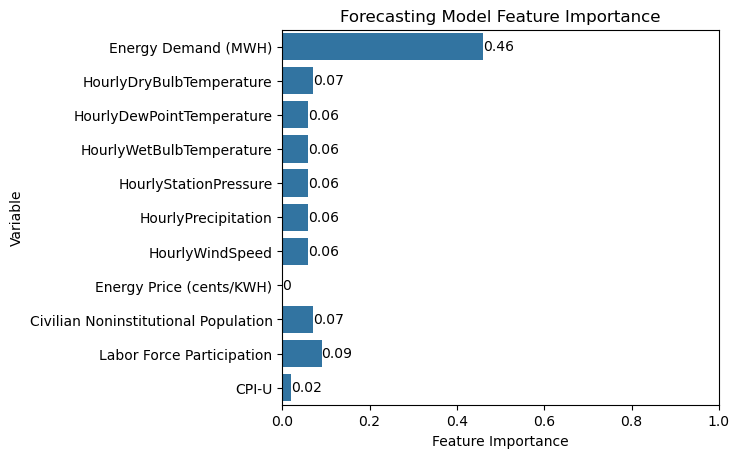

In [44]:
# Sensitivity Analysis for day-ahead forecasts \
feature_importances = pd.Series(mse_diffs)
feature_importances = feature_importances - feature_importances.min()
feature_importances = (feature_importances / feature_importances.sum()).round(2)
sa_fig = plt.figure(figsize=(8,5))
ax = sa_fig.add_subplot()
sns.barplot(x=feature_importances.values, y=feature_importances.index)
ax.bar_label(ax.containers[0])
ax.set_ylabel("Variable")
ax.set_xlabel("Feature Importance")
ax.set_title("Forecasting Model Feature Importance")
ax.set_xlim([0,1])
plt.tight_layout()
pp.save_png_encoded(r'assets/sensitivity_analysis.png', sa_fig)

### Create Report for Download on the Web Application

In [48]:
from plotly.io import to_html
with open(r"assets/model_performance_report.html", "w") as file:
    file.write("""
        <!DOCTYPE html>
        <html>
        <head>
        <title> Energy Demand Forecasting Model Performance Report </title>
        </head>
        <body>
        <H1> Energy Demand Forecasting Model Performance Report </H1>
        <div style="width: 75%;">The following report contains model performance metrics for the NY City Hourly Probabilistic Residential Energy Demand Forecasting Pipeline. 
            Model performance was evaluated on both long-term and day-ahead forecasts. Evaluation was conducted using a holdout dataset of hourly energy 
            demand values between {} and {}.
        <br>
        <H3> Long-Term Forecasting Performance </H3>
        <div style="width: 75%;"> The following table contains performance metrics for the forecasting model compared with a yearly moving average baseline model.</div>
        <div style="width: 75%;">{}</div>
        <br>
        <div style="width: 75%;"> The following Plotly Figure helps to contextualize the forecasting model's performance by showing its predictions along with the actual energy demand 
            values. It also presents the 95% confidence interval bounds estimated by the forecasting model.</div>
        <div style="width: 75%;">{}</div>
        <br> <br> <br>  
        <H3> Day-Ahead Forecasting Performance </H3>
        <div style="width: 75%;"> The following table contains performance metrics for the forecasting model compared with a yearly moving average baseline model.</div>
        <div style="width: 75%;">{}</div>
        <br>
        <divs style="width: 75%;"> The following Plotly Figure helps to contextualize the forecasting model's performance by showing its predictions along with the actual energy demand 
            values. It also presents the 95% confidence interval bounds estimated by the forecasting model. </div>
        <div style="width: 75%;">{}</div>
        <br> <br> <br>
        <H3>Model Sensitivity Analysis</H3>
        <div style="width: 75%;">The following data has been made up for demonstration purposes. Actual data will be provided in a future update.</div>
        <br>
        <img src="{}" width="50%" alt="Sensitivity Analysis">
        </body>
        """.format(evaluation_data.index.min().strftime("%Y-%m-%d"), evaluation_data.index.max().strftime("%Y-%m-%d"), long_results_df.to_html(), 
            to_html(long_term_fig), day_ahead_results_df.to_html(), to_html(short_term_fig), r"sensitivity_analysis.png"))

## Produce Final Model and Predict into the Future

### Fit Model on All Available Data

In [ ]:
# create new processing pipeline to process all data but not create visuals
processor = pp.PreprocessingPipeline(save_datasets=False, produce_eda_plots=False)
final_train_data,_ = processor.process_dataset(preliminary_dataset=preliminary_data, split_into_train_holdout=False)

In [ ]:
# fit final model on all available data
final_model = md.Forecaster()
final_model.fit(clean_training_data=final_train_data, dependent_variable="Energy Demand (MWH)", 
    strong_predictors=["HourlyDryBulbTemperature"], hyperparameters=best_set)

In [ ]:
# Forecast 2 years into the future
future_point_forecasts, future_variance_forecasts = final_model.predict(hours_ahead=365*24*2)

In [ ]:
# produce plot showing 2 year forecast
# Combine error forecasts
std_forecasts = np.sqrt(future_variance_forecasts)

# 1.96 is the z-value for the 2.5th percentile of the standard normal distribution
lower_cuts = future_point_forecasts - 1.96 * std_forecasts  
upper_cuts = future_point_forecasts + 1.96 * std_forecasts

# Create figure showing forecasts and actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=future_point_forecasts.index, y=future_point_forecasts, mode='lines', 
    name='Point Forecasts', line=dict(color='rgba(255, 0, 0)')))
fig.add_trace(go.Scatter(x=future_point_forecasts.index, y=upper_cuts, mode='lines', 
    name='Upper 95 CI', line=dict(color='rgba(0, 255, 0, 0.2)')))
fig.add_trace(go.Scatter(x=future_point_forecasts.index, y=lower_cuts, mode='lines', 
    name='Lower 95 CI', line=dict(color='rgba(200, 125, 200, 0.2)')))

# Customize the layout
fig.update_layout(
    title="Evaluating Forecasting Pipeline with Holdout Data",
    xaxis_title='Time',
    yaxis_title='Energy Demand (MWH)',
    template='plotly_dark',
    xaxis=dict(range=[future_point_forecasts.index[0],future_point_forecasts.index[-1]])
)

In [ ]:
# save plotly figure for web app
with open(r"Saved/Plotly Figures/Forecasting/future_forecasts.pkl", 'wb') as file:
    pkl.dump(fig, file=file)

# save future forecasts as csv for web app
future_forecasts = pd.concat([future_point_forecasts.rename("Point Forecast"), future_variance_forecasts.rename("Variance Forecast")], 
    axis=1).rename_axis("Time").reset_index()
future_forecasts.to_csv("assets/future_forecasts.csv")